# Imports and functions

In [1]:
import pandas as pd
import spacy
import string
# load the language library
nlp = spacy.load('pt_core_news_sm')
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
import collections

In [2]:
## helper functions
def normalize_words(mess):
    norm = [char for char in mess if char not in string.punctuation ]
    norm = ''.join(norm)
#     norm = norm.lower()
    return norm

def estado(location):
    lst=location.split(',')
    try: return lst[1].strip()
    except IndexError: return lst[-1].strip()
    
def filter_nouns(cell):
    # Create a Doc object
    doc = nlp(cell)
    aux=[]
    # Print each token separately
    for token in doc:
        if (token.pos_ in ['PROPN']) and (token.text not in ['Show','less']):
            aux.append(token.text)
    return aux

def filter_ents(cell):
    aux=[]
    for ent in cell.ents:
        aux.append(ent.text)
    return aux

def find_salary(cell):
    wordsAfter=''
    for index,token in enumerate(cell): 
        if token.text == "R$":
            wordsAfter+=cell[index:index+4].text+' '
#         elif token.text.lower() in ['salário','salario']:
#             wordsAfter+=cell[index:index+5].text
    return wordsAfter

def filter_NUM(cell):
    # Create a Doc object
    doc = nlp(cell)
    sal=''
    # Print each token separately
    for token in doc:
        if token.pos_ == 'NUM':
            sal=token.text
    return sal

In [3]:
df=pd.read_csv('LinkedIn Job Data.csv')

In [4]:
df.sample(5)

,Job ID,Date,Company Name,Post,Location,Description,Level,Type,Function,Industry
378,2153525851,2020-08-25,Líder e Gestão,Analista De Qualidade - Porto Alegre - RS,"Porto Alegre, Rio Grande do Sul, Brazil",Titulo:Analista de Qualidade - Porto Alegre - ...,Associate,Full-time,Quality Assurance,Information Technology and ServicesStaffing an...
377,2156450907,2020-09-09,Assessoriaserh,Engenheiro Mecânico,"Curitiba, Paraná, Brazil","Experiência irá desenvolver, projetar, supervi...",Entry level,Full-time,EngineeringInformation Technology,Food & BeveragesStaffing and RecruitingHuman R...
413,1854198296,2020-05-08,Thomas Técnica Coml Elem Transmissão Ltda,Representante Comercial,"Belo Horizonte, Minas Gerais, Brazil","Empresade atuação no mercado, busca representa...",Entry level,Full-time,SalesManagement,Electrical/Electronic ManufacturingHigher Educ...
316,2020024005,2020-09-04,Time-Now Engenharia S/A,Gerente de Contrato - Joinville/SC - 474338,"Joinville, Santa Catarina, Brazil",Estamos com uma oportunidade para atuar como G...,Associate,Full-time,ManagementManufacturing,Industrial Automation
506,2147912379,2020-08-21,Amyris,Planejador de Obra - Pleno (PJ/Barra Bonita),"Barra Bonita, São Paulo, Brazil",Requisitos\nEnsino superior completo em: Engen...,Associate,Full-time,Other,Biotechnology


# Análise univariada e data featuring

## Level

Maioria das funções são de iniciantes

In [5]:
df['Level'].value_counts()

Entry level         314
Associate           114
Mid-Senior level     89
Internship           59
Not Applicable       18
Executive             5
Director              2
Name: Level, dtype: int64

In [6]:
Level = pd.get_dummies(df['Level'],drop_first=True)

In [7]:
Level=Level.drop(['Not Applicable'],axis=1)

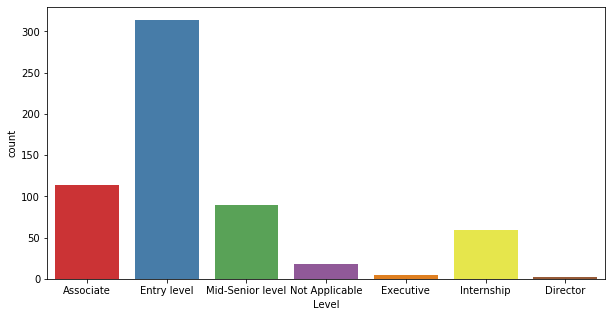

In [8]:
plt.subplots(figsize=(10,5))
sns.countplot(x='Level',data=df,palette='Set1')

## Type

Dados provavelmente errados uma vez que existem várias vagas de estágio

In [9]:
df['Type'].value_counts()

Full-time     594
Part-time       4
Internship      2
Temporary       1
Name: Type, dtype: int64

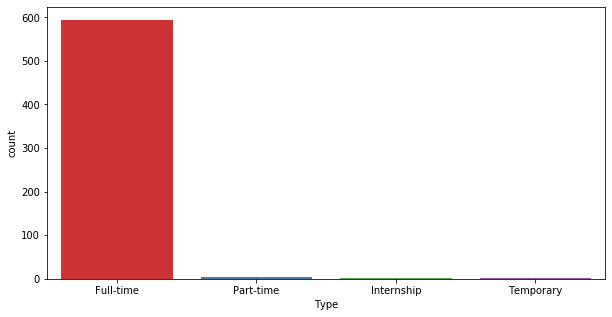

In [10]:
plt.subplots(figsize=(10,5))
sns.countplot(x='Type',data=df,palette='Set1')

## Post

Maioria das vagas levam engenheiro e manutenção no título

In [12]:
aux=df['Post'].str.lower()
aux=aux.str.replace('é','e')
aux=aux.str.replace('á','a')

In [13]:
Nivel=pd.DataFrame()
Nivel['estágio']=aux.apply(lambda x: 1 if 'estag' in x else 0)
Nivel['supervisor']=aux.apply(lambda x: 1 if 'supervisor' in x else 0)
# Nivel['projetista']=aux.apply(lambda x: 1 if 'projetista' in x else 0)
Nivel['engenheiro']=aux.apply(lambda x: 1 if 'engenheiro' in x else 0)
Nivel['assistente']=aux.apply(lambda x: 1 if 'assistente' in x else 0)
Nivel['analista']=aux.apply(lambda x: 1 if 'analista' in x else 0)
Nivel['gerente']=aux.apply(lambda x: 1 if 'gerente' in x else 0)
Nivel['coordenador']=aux.apply(lambda x: 1 if 'coordenador' in x else 0)
Nivel['especialista']=aux.apply(lambda x: 1 if 'especialista' in x else 0)

[Text(0, 0, 'engenheiro'),
 Text(0, 0, 'estágio'),
 Text(0, 0, 'analista'),
 Text(0, 0, 'supervisor'),
 Text(0, 0, 'gerente'),
 Text(0, 0, 'coordenador'),
 Text(0, 0, 'assistente'),
 Text(0, 0, 'especialista')]

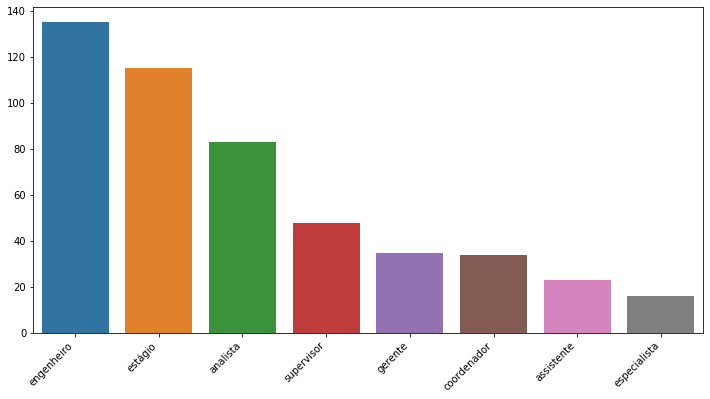

In [14]:
plt.subplots(figsize=(12,6))
aux1=Nivel.sum().sort_values(ascending=False)
g=sns.barplot(aux1.index,aux1.values)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [15]:
aux1

engenheiro      135
estágio         115
analista         83
supervisor       48
gerente          35
coordenador      34
assistente       23
especialista     16
dtype: int64

In [16]:
funcao=pd.DataFrame()
funcao['projetos']=aux.apply(lambda x: 1 if 'projet' in x else 0)
funcao['manutenção']=aux.apply(lambda x: 1 if 'manut' in x else 0)
funcao['qualidade']=aux.apply(lambda x: 1 if 'quali' in x else 0)
funcao['segurança do trabalho']=aux.apply(lambda x: 1 if 'segurança do trabalho' in x else 0)
funcao['produção']=aux.apply(lambda x: 1 if 'produç' in x else 0)

[Text(0, 0, 'manutenção'),
 Text(0, 0, 'projetos'),
 Text(0, 0, 'produção'),
 Text(0, 0, 'qualidade'),
 Text(0, 0, 'segurança do trabalho')]

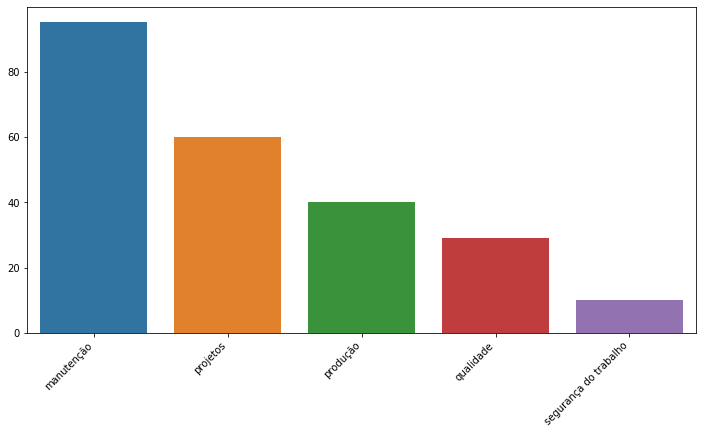

In [17]:
plt.subplots(figsize=(12,6))
aux2=funcao.sum().sort_values(ascending=False)
g=sns.barplot(aux2.index,aux2.values)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [18]:
aux2

manutenção               95
projetos                 60
produção                 40
qualidade                29
segurança do trabalho    10
dtype: int64

## Location

Maioria das vagas são em SP

In [19]:
Loc=pd.DataFrame()

In [20]:
Loc['Location']=df['Location'].apply(estado)

In [21]:
Loc['Location']=Loc['Location'].str.replace('Greater Belo Horizonte','Minas Gerais') \
.replace('Greater Sao Paulo','São Paulo').replace('Greater Salvador','Salvador') \
.replace('Greater Curitiba','Curitiba').replace('Greater Manaus','Manaus').replace('Greater Rio de Janeiro','Rio de Janeiro') \
.replace('Brazil','NA').replace('Brazil Metropolitan Area','NA').replace('Paraiba','Paraíba')

[Text(0, 0, 'São Paulo'),
 Text(0, 0, 'Minas Gerais'),
 Text(0, 0, 'Paraná'),
 Text(0, 0, 'Rio Grande do Sul'),
 Text(0, 0, 'Rio de Janeiro'),
 Text(0, 0, 'Santa Catarina'),
 Text(0, 0, 'Pará'),
 Text(0, 0, 'Amazonas'),
 Text(0, 0, 'Mato Grosso'),
 Text(0, 0, 'Bahia')]

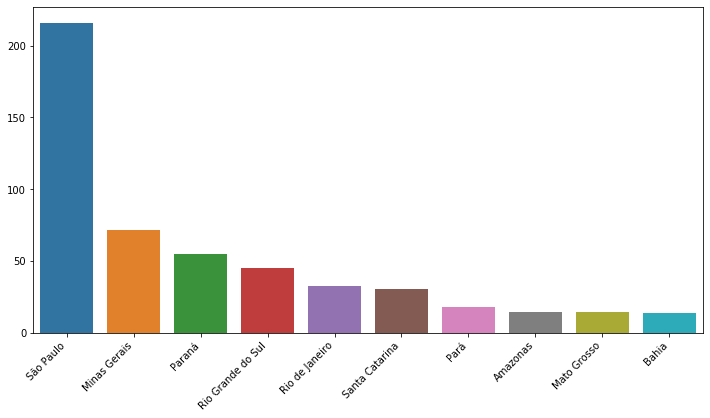

In [22]:
# 10 estados com mais vagas
plt.subplots(figsize=(12,6))
aux=Loc['Location'].value_counts()[0:10]
g=sns.barplot(aux.index,aux.values)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [23]:
Loc['Location'].value_counts()

São Paulo             216
Minas Gerais           72
Paraná                 55
Rio Grande do Sul      45
Rio de Janeiro         33
Santa Catarina         31
Pará                   18
Amazonas               15
Mato Grosso            15
Bahia                  14
Ceará                  13
Goiás                  12
Federal District       11
NA                      9
Espírito Santo          8
Pernambuco              6
Maranhão                6
Mato Grosso do Sul      5
Tocantins               3
Manaus                  3
Alagoas                 2
Salvador                2
Paraíba                 2
Sergipe                 2
Curitiba                1
Amapá                   1
Piauí                   1
Name: Location, dtype: int64

In [24]:
loc_cat=Loc
Loc=pd.get_dummies(loc_cat,drop_first=False,prefix='',prefix_sep='')
Loc=Loc[['São Paulo','Minas Gerais','Paraná','Rio Grande do Sul','Rio de Janeiro','Santa Catarina','Pará']]

In [25]:
Nordeste=['Maranhão','Piauí','Ceará','Rio Grande do Norte','Paraíba','Pernambuco','Alagoas','Sergipe','Bahia']
Sul=['Paraná','Santa Catarina','Rio Grande do Sul']
Norte=['Amazonas','Pará','Tocantins','Rondônia','Acre','Amapá','Roraima']
Centro_Oeste=['Mato Grosso','Mato Grosso do Sul','Goiás','Distrito Federal','Federal District']
Sudeste=['Minas Gerais','Rio de Janeiro','Espírito Santo','São Paulo']

loc_cat['Location']=loc_cat['Location'].apply(lambda x: 'Nordeste' if x in Nordeste else x)
loc_cat['Location']=loc_cat['Location'].apply(lambda x: 'Sul' if x in Sul else x)
loc_cat['Location']=loc_cat['Location'].apply(lambda x: 'Norte' if x in Norte else x)
loc_cat['Location']=loc_cat['Location'].apply(lambda x: 'Centro_Oeste' if x in Centro_Oeste else x)
loc_cat['Location']=loc_cat['Location'].apply(lambda x: 'Sudeste' if x in Sudeste else x)

[Text(0, 0, 'Sudeste'),
 Text(0, 0, 'Sul'),
 Text(0, 0, 'Nordeste'),
 Text(0, 0, 'Centro_Oeste'),
 Text(0, 0, 'Norte')]

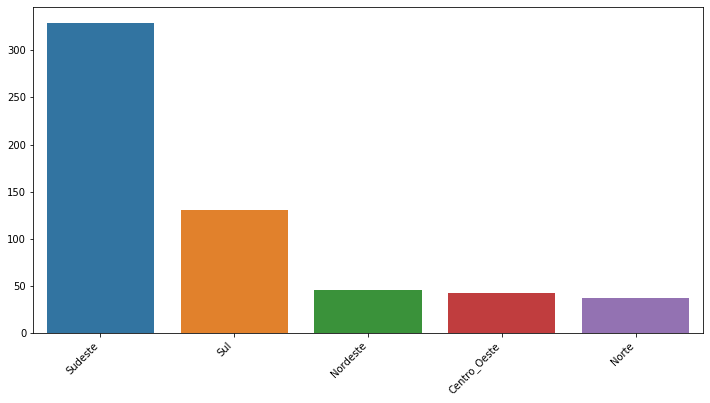

In [26]:
# Distribuição de vagas nos estados
plt.subplots(figsize=(12,6))
aux=loc_cat['Location'].value_counts()[0:5]
g=sns.barplot(aux.index,aux.values)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

## Function

Esta análise não mostrou muita coisa uma vez que a maioria das empresas colocam a função da vaga como RH ou TI

In [27]:
func=pd.DataFrame()

In [28]:
func['Project Management']=df['Function'].apply(lambda x: 1 if 'Project Management' in x else 0)
func['Engineering']=df['Function'].apply(lambda x: 1 if 'Engineering' in x else 0)
func['Information Technology']=df['Function'].apply(lambda x: 1 if 'Information Technology' in x else 0)
func['Education']=df['Function'].apply(lambda x: 1 if 'Education' in x else 0)
func['Other']=df['Function'].apply(lambda x: 1 if 'Other' in x else 0)
func['Business Development']=df['Function'].apply(lambda x: 1 if 'Business Development' in x else 0)
func['Sales']=df['Function'].apply(lambda x: 1 if 'Sales' in x else 0)
func['Quality Assurance']=df['Function'].apply(lambda x: 1 if 'Quality Assurance' in x else 0)
func['Administrative']=df['Function'].apply(lambda x: 1 if 'Administrative' in x else 0)
func['DesignArt/Creative']=df['Function'].apply(lambda x: 1 if 'DesignArt/Creative' in x else 0)
func['Purchasing']=df['Function'].apply(lambda x: 1 if 'Purchasing' in x else 0)
func['Supply Chain']=df['Function'].apply(lambda x: 1 if 'Supply Chain' in x else 0)
func['Manufacturing']=df['Function'].apply(lambda x: 1 if 'Manufacturing' in x else 0)
func['Production']=df['Function'].apply(lambda x: 1 if 'Production' in x else 0)
func['Research']=df['Function'].apply(lambda x: 1 if 'Research' in x else 0)
func['Management']=df['Function'].apply(lambda x: 1 if (('Management' in x) and ('Project' not in x)) else 0)
func['Analyst']=df['Function'].apply(lambda x: 1 if 'Analyst' in x else 0)

[Text(0, 0, 'Information Technology'),
 Text(0, 0, 'Engineering'),
 Text(0, 0, 'Management'),
 Text(0, 0, 'Manufacturing'),
 Text(0, 0, 'Sales'),
 Text(0, 0, 'Education'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Business Development'),
 Text(0, 0, 'Project Management'),
 Text(0, 0, 'Quality Assurance'),
 Text(0, 0, 'Administrative'),
 Text(0, 0, 'DesignArt/Creative'),
 Text(0, 0, 'Supply Chain'),
 Text(0, 0, 'Purchasing'),
 Text(0, 0, 'Production'),
 Text(0, 0, 'Analyst'),
 Text(0, 0, 'Research')]

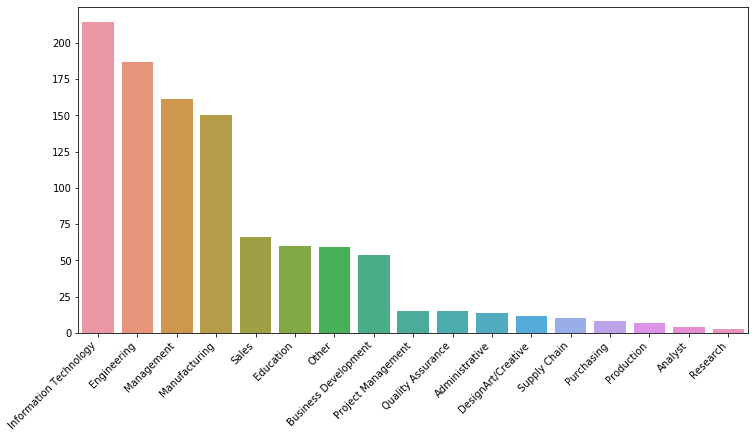

In [29]:
plt.subplots(figsize=(12,6))
aux=func.sum().sort_values(ascending=False)
g=sns.barplot(aux.index,aux.values)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

## Industry

Esta análise não mostrou muita coisa uma vez que a maioria das empresas colocam a indústria da vaga como RH ou TI

In [30]:
Indus=pd.DataFrame()

Indus['Staffing and Recruiting']=df['Industry'].apply(lambda x: 1 if ('Information Technology and Services' in x) or\
                                                      ('Staffing and Recruiting' in x) or \
                                                      ('Human Resources' in x) else 0)

Indus['Food Production']=df['Industry'].apply(lambda x: 1 if ('Food & Beverages' in x) or \
                                              ('Food Production' in x) else 0)

Indus['Mechanical or Industrial Engineering']=df['Industry'].apply(lambda x: 1 if 'Mechanical or Industrial Engineering' in x else 0)

Indus['Management Consulting']=df['Industry'].apply(lambda x: 1 if 'Management Consulting' in x else 0)

Indus['Civil Engineering']=df['Industry'].apply(lambda x: 1 if ('Civil Engineering' in x) or \
                                                ('Construction' in x) else 0)

Indus['Industrial Automation']=df['Industry'].apply(lambda x: 1 if 'Industrial Automation' in x else 0)
Indus['Electrical/Electronic Manufacturing']=df['Industry'].apply(lambda x: 1 if 'Electrical/Electronic Manufacturing' in x else 0)
Indus['Mining & Metals']=df['Industry'].apply(lambda x: 1 if 'Mining & Metals' in x else 0)
Indus['Automotive']=df['Industry'].apply(lambda x: 1 if 'Automotive' in x else 0)
Indus['Airlines/AviationAviation & Aerospace']=df['Industry'].apply(lambda x: 1 if 'Airlines/AviationAviation & Aerospace' in x else 0)
Indus['Paper & Forest Products']=df['Industry'].apply(lambda x: 1 if 'Paper & Forest Products' in x else 0)
Indus['Renewables & Environment']=df['Industry'].apply(lambda x: 1 if 'Renewables & Environment' in x else 0)
Indus['Oil & Energy']=df['Industry'].apply(lambda x: 1 if 'Oil & Energy' in x else 0)


[Text(0, 0, 'Staffing and Recruiting'),
 Text(0, 0, 'Mechanical or Industrial Engineering'),
 Text(0, 0, 'Civil Engineering'),
 Text(0, 0, 'Food Production'),
 Text(0, 0, 'Electrical/Electronic Manufacturing'),
 Text(0, 0, 'Management Consulting'),
 Text(0, 0, 'Industrial Automation'),
 Text(0, 0, 'Renewables & Environment'),
 Text(0, 0, 'Oil & Energy'),
 Text(0, 0, 'Automotive'),
 Text(0, 0, 'Mining & Metals'),
 Text(0, 0, 'Paper & Forest Products'),
 Text(0, 0, 'Airlines/AviationAviation & Aerospace')]

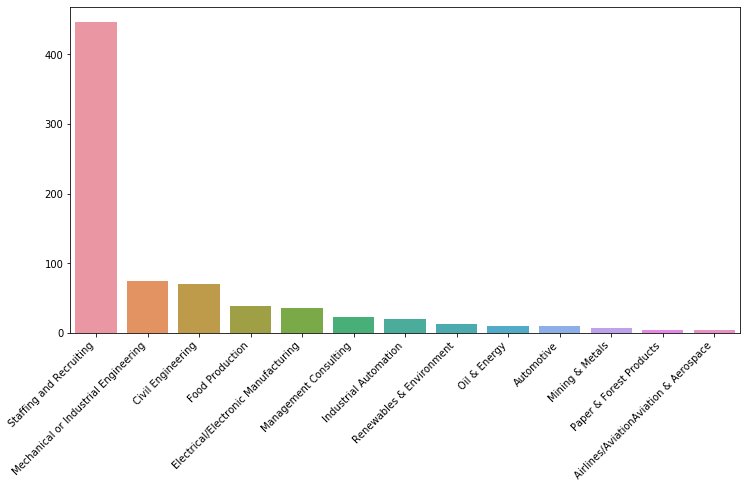

In [31]:
plt.subplots(figsize=(12,6))
aux=Indus.sum().sort_values(ascending=False)
g=sns.barplot(aux.index,aux.values)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

## Description

### Comprimento da descrição

In [32]:
df['description_length'] = df['Description'].apply(len)

In [33]:
df['description_length'].describe()

count     601.000000
mean     1259.336106
std       979.257840
min        72.000000
25%       589.000000
50%       931.000000
75%      1691.000000
max      7173.000000
Name: description_length, dtype: float64

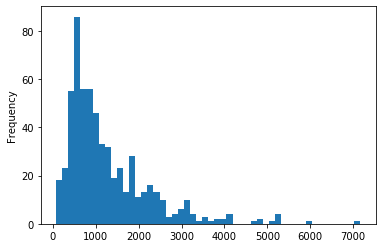

In [34]:
# Distribuição do número de caracteres da descrição da vaga
df['description_length'].plot(bins=50, kind='hist') 

### Substantivos comuns e próprios mais usados

In [35]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
punctuation='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [37]:
stopwords=list(nlp.Defaults.stop_words)

In [38]:
Desc=df['Description'].apply(normalize_words)
Desc=Desc.apply(filter_nouns)
Desc=Desc.apply(lambda ls: [word.strip().lower() for word in ls])

In [39]:
# junta e forma dataframe de palavras
lst=[element for list_ in Desc for element in list_]  
words=pd.DataFrame({'Number': lst})

In [40]:
top=pd.DataFrame()
for i in range(0,6):
    lim=10
    top=pd.concat([top,pd.DataFrame(words['Number'].value_counts()[(i*lim):(i*lim+lim)]).reset_index()],axis=1)

In [41]:
top

,index,Number,index,Number,index,Number,index,Number,index,Number,index,Number
0,engenharia,922,integral,133,trabalho,114,projetos,89,graduação,76,elaborar,64
1,mecânica,552,pacote,128,empresa,107,completo,89,conhecimentos,74,sap,63
2,superior,192,and,127,–,107,job,87,brasil,73,química,62
3,gestão,178,período,127,são,107,requisitos,83,vida,73,recrutamento,62
4,elétrica,177,vale,126,excel,104,local,81,controle,73,transporte,61
5,office,171,cargo,125,the,103,jornada,80,seguro,69,to,61
6,produção,169,benefícios,121,plano,98,qualidade,79,description,67,industrial,60
7,manutenção,165,inglês,120,horário,92,sp,79,segurança,64,of,60
8,ensino,152,mecatrônica,117,ramo,89,paulo,79,estágio,64,cursando,57
9,conhecimento,133,formação,114,clt,89,área,77,humanos,64,analista,57


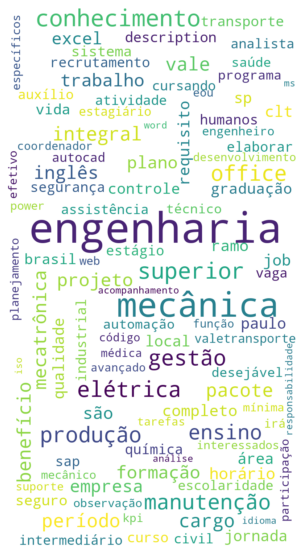

In [42]:
text=' '.join(lst)
wc= WordCloud(background_color="white", random_state=1, max_words = 100, width =800, height = 1500,collocations=False)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

### Named entities mais usados

In [43]:
Desc1=df['Description'].apply(nlp).apply(filter_ents)

In [44]:
Desc1=Desc1.apply(lambda ls: [word.strip().lower() for word in ls])

In [45]:
lst=[element for list_ in Desc1 for element in list_]
words=pd.DataFrame({'Number': lst}) 

In [46]:
words_dict=pd.DataFrame(words['Number'].value_counts()).to_dict()['Number']
keys_to_remove = ['show less','descrição\ncódigo'] 
for key in keys_to_remove:
    del words_dict[key]

In [72]:
# words_dict

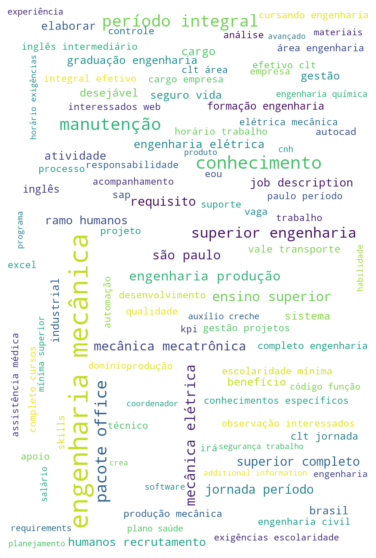

In [48]:
wc=WordCloud(background_color="white", random_state=1, max_words = 100, width =1000, height = 1500).generate_from_frequencies(words_dict)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()
# ,collocations=False

### Procurando habilidades específicas nas descrições

Com base nas palavras-chave das seções 2.7.3 e 2.7.2 é possível filtrar manualmente as palavras-chave mais comuns

Destaque para SAP, Lean Manufacturing, AutoCad e Gestão de projetos

In [50]:
def verify_strings(cell,matches=['']):
    a_string=' '.join(cell)
    if any(x in a_string for x in matches):
        return 1
    else:
        return 0

In [51]:
habil=pd.DataFrame()
habil['SAP'] = Desc1.apply(verify_strings,matches=['sap','sap-'])
habil['Manutenção'] = Desc1.apply(verify_strings,matches=['manutenção'])
habil['Pacote Office/excel'] = Desc1.apply(verify_strings,matches=['office','excel'])
habil['Autocad'] = Desc1.apply(verify_strings,matches=['autocad'])
habil['fmea'] = Desc1.apply(verify_strings,matches=['fmea'])
habil['SolidWorks'] = Desc1.apply(verify_strings,matches=['solidworks'])
habil['Power BI'] = Desc1.apply(verify_strings,matches=['power bi'])
habil['Gestão de Projetos'] = Desc1.apply(verify_strings,matches=['gestão de projetos'])
habil['KPI'] = Desc1.apply(verify_strings,matches=['kpi'])
habil['MS Project'] = Desc1.apply(verify_strings,matches=['ms project','ms-project','msproject'])
habil['Green Belt/Black Belt'] = Desc1.apply(verify_strings,matches=['belt'])
habil['Segurança do Trabalho'] = Desc1.apply(verify_strings,matches=['segurança do trabalho'])
habil['Lean Manufacturing/Six Sigma'] = Desc1.apply(verify_strings,matches=['lean'])

[Text(0, 0, 'Pacote Office/excel'),
 Text(0, 0, 'Manutenção'),
 Text(0, 0, 'Autocad'),
 Text(0, 0, 'SAP'),
 Text(0, 0, 'KPI'),
 Text(0, 0, 'Gestão de Projetos'),
 Text(0, 0, 'Lean Manufacturing/Six Sigma'),
 Text(0, 0, 'MS Project'),
 Text(0, 0, 'SolidWorks'),
 Text(0, 0, 'fmea'),
 Text(0, 0, 'Segurança do Trabalho'),
 Text(0, 0, 'Power BI'),
 Text(0, 0, 'Green Belt/Black Belt')]

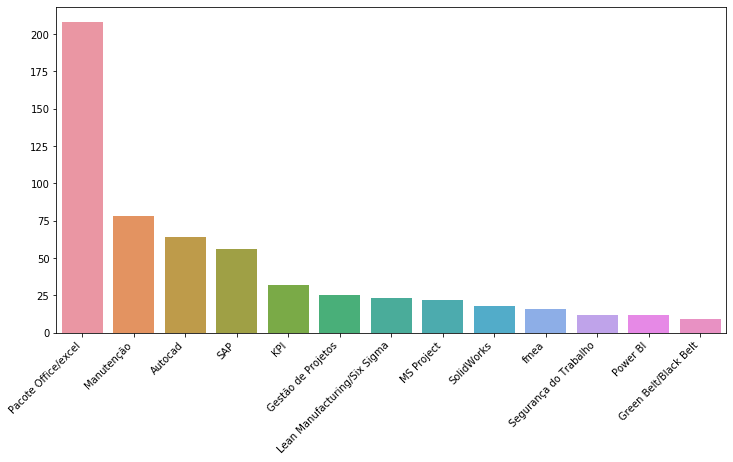

In [52]:
plt.subplots(figsize=(12,6))
aux=habil.sum().sort_values(ascending=False)
g=sns.barplot(aux.index,aux.values)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

## Salary

In [53]:
sal=df['Description'].replace('$','$ ').apply(nlp).apply(find_salary)

In [54]:
sal=sal[sal!=''].apply(filter_NUM)
sal[234]='' #clean this specific string
sal=sal[sal!=''] #pick non-empty values

In [55]:
# clean strings
sal=sal.str.replace(',00','')
sal=sal.str.replace('.','')
sal=sal.str.replace(',88','')

In [56]:
sal=sal.apply(int) #transform to integer

In [57]:
sal=sal.rename('Salary')

In [58]:
sal.describe()

count       44.000000
mean      4464.590909
std       4514.079573
min        600.000000
25%       1289.750000
50%       3056.500000
75%       5000.000000
max      16500.000000
Name: Salary, dtype: float64

# Análise bivariada comparando salário

salário de analista é muito baixo

In [59]:
def dummy2cat(df):
    x=df.stack()
    df_cat=pd.Series(x[x!=0].index.get_level_values(1),index=x[x!=0].index.get_level_values(0))
    df_cat = df_cat[~df_cat.index.duplicated(keep='first')]
    return df_cat

In [60]:
Nivel_cat=dummy2cat(Nivel)

In [61]:
aux=pd.concat([sal,Nivel_cat],axis=1)

Apenas 44 vagas falaram de salário, esse número não é alto o bastante para um modelo de ML

In [62]:
aux

,Salary,0
0,NaN,analista
1,16500.0,engenheiro
2,NaN,engenheiro
3,NaN,engenheiro
4,16500.0,gerente
...,...,...
592,NaN,estágio
593,NaN,engenheiro
596,10000.0,supervisor
599,NaN,estágio


In [63]:
aux=aux.rename(columns={0:'Nivel'})
aux=aux[aux['Nivel']!='especialista']

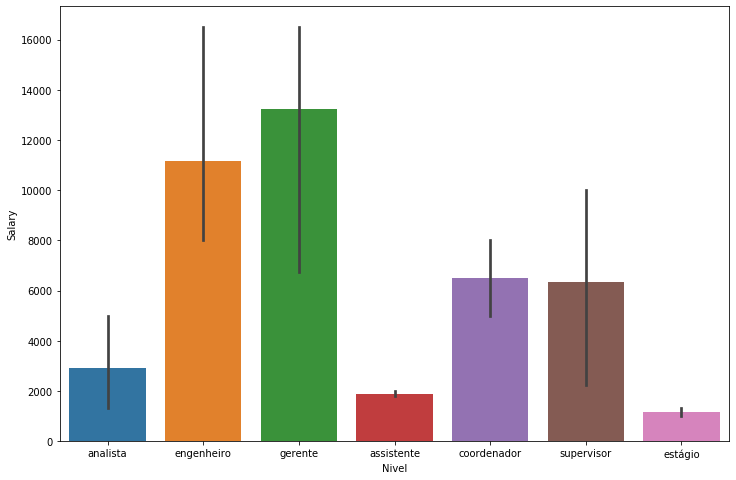

In [64]:
plt.figure(figsize=[12,8])
sns.barplot(x='Nivel',y='Salary',data=aux)

In [65]:
aux.groupby('Nivel').mean()

,Salary
Nivel,
analista,2921.250000
assistente,1900.000000
coordenador,6500.000000
engenheiro,11166.666667
estágio,1176.285714
gerente,13250.000000
supervisor,6349.333333


# Análise multivariada

## Nivel-funcao-salario

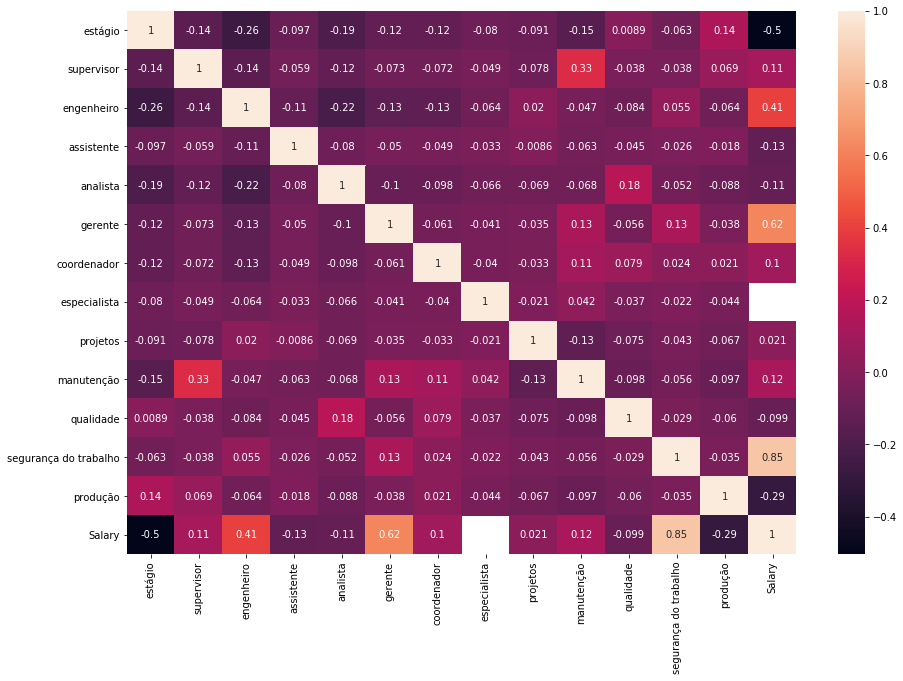

In [74]:
correlate=pd.concat([Nivel,funcao,sal],axis=1)
plt.subplots(figsize=(15,10))
sns.heatmap(correlate.corr(),annot=True)

## Nivel-senioridade-salario

Maioria das vagas entry-level estão como engenheiro, mid-senior estão como supervisor

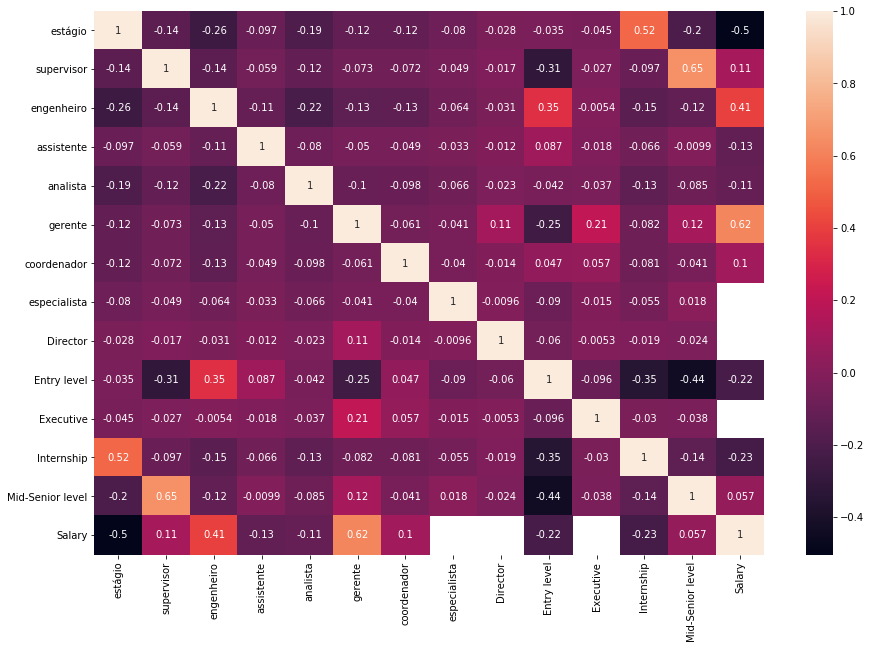

In [75]:
correlate=pd.concat([Nivel,Level,sal],axis=1)
plt.subplots(figsize=(15,10))
sns.heatmap(correlate.corr(),annot=True)

## Funcao-senioridade-salario

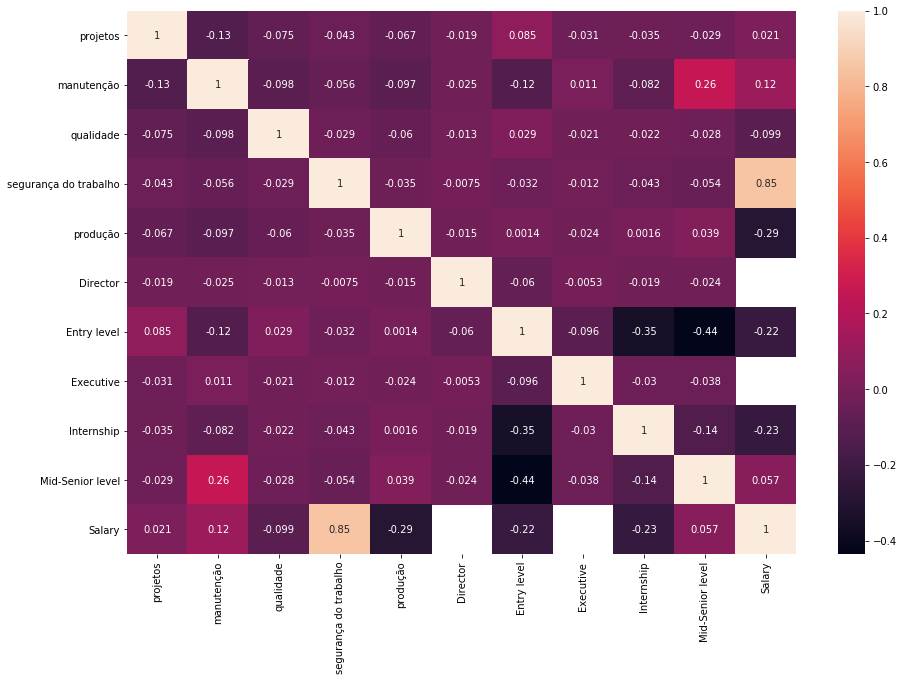

In [76]:
correlate=pd.concat([funcao,Level,sal],axis=1)
plt.subplots(figsize=(15,10))
sns.heatmap(correlate.corr(),annot=True)

## Industria-localidade-salario

Alta correlacao de MG com Mineracao e Para com engenharia civil

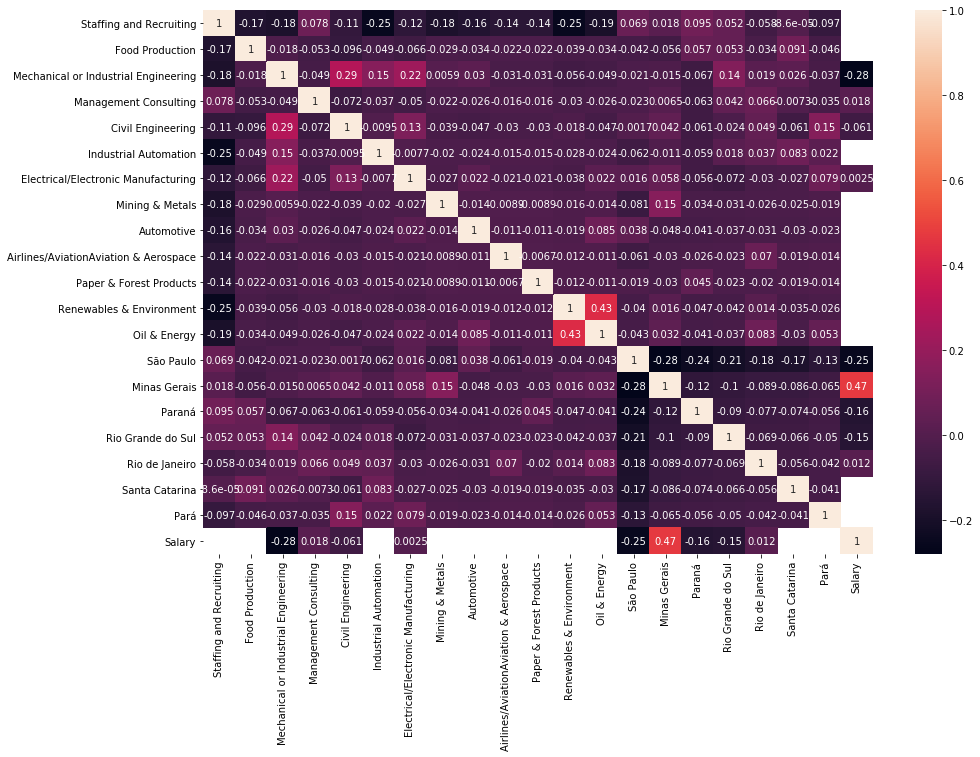

In [77]:
correlate=pd.DataFrame()
correlate=pd.concat([Indus,Loc,sal],axis=1)
plt.subplots(figsize=(15,10))
sns.heatmap(correlate.corr(),annot=True)

## Nivel-localidade-salario

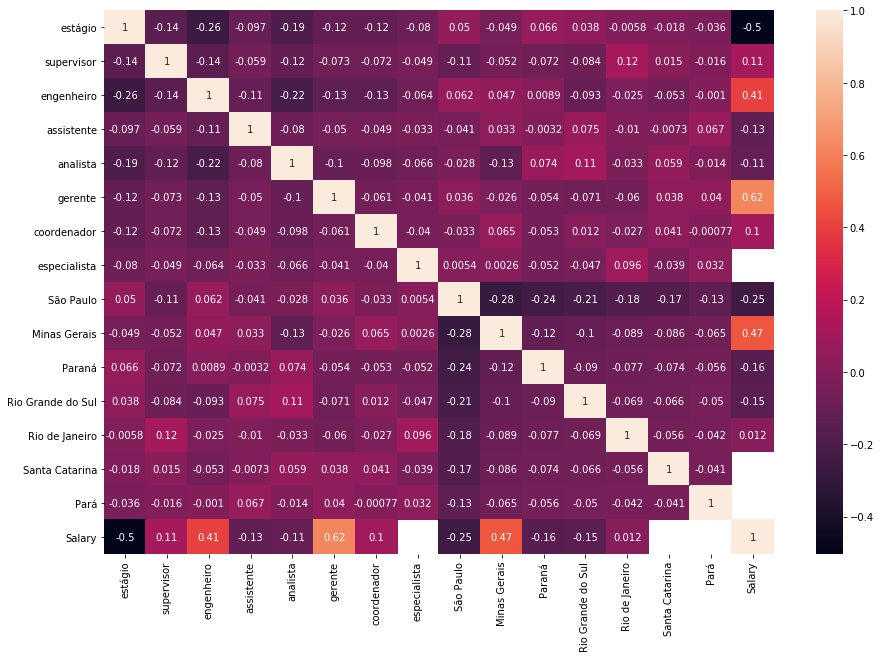

In [78]:
correlate=pd.concat([Nivel,Loc,sal],axis=1)
plt.subplots(figsize=(15,10))
sns.heatmap(correlate.corr(),annot=True)

## Função-habilidades-salario

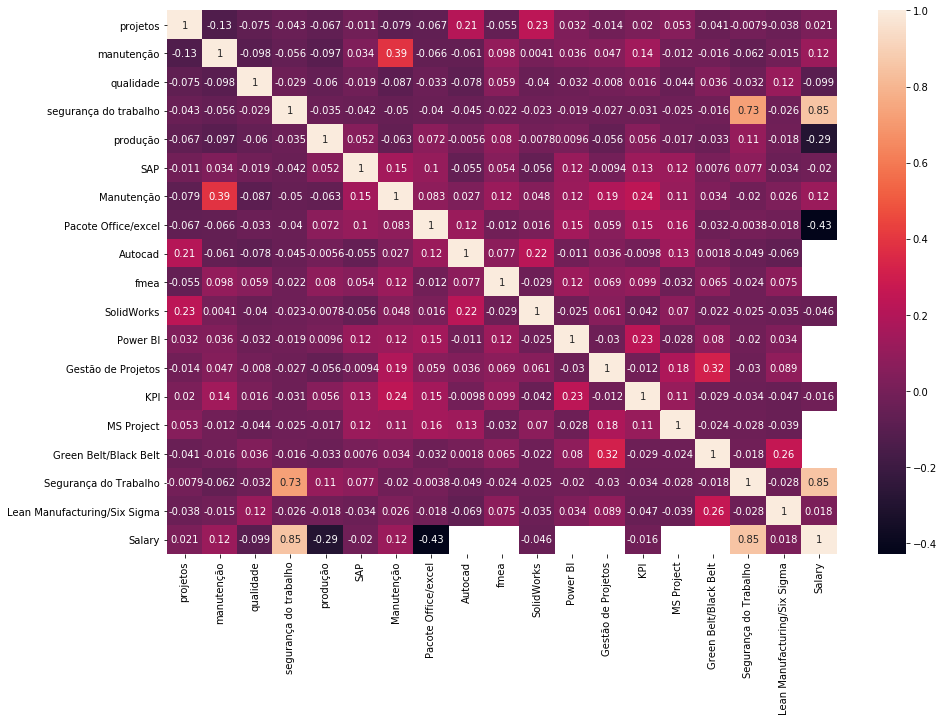

In [81]:
correlate=pd.concat([funcao,habil,sal],axis=1)
plt.subplots(figsize=(15,10))
sns.heatmap(correlate.corr(),annot=True)